In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers, Input
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [2]:
# reuters 데이터셋 로드
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=100)


# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))  # 훈련 데이터셋 크기
print(len(val_data))  # 검증 데이터셋 크기
print(len(test_data))  # 테스트 데이터셋 크기
print(len(set(train_labels)))  # 레이블 종류 수


6736
2246
2246
46


In [3]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, sequence in enumerate(data):
        results[i, sequence] = 1.
    return results

# 원-핫 인코딩 수행
x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
# 레이블 데이터 범주형으로 변환
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_val_labels = to_categorical(val_labels)
one_hot_test_labels = to_categorical(test_labels)


In [4]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
# 딥러닝 모델 구성
# 모델 구성
inputs = Input(shape=(10000,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(46, activation='softmax')(x)

# 모델 인스턴스 생성
model = models.Model(inputs=inputs, outputs=outputs)

# 모델 컴파일
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [6]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
# 콜백 함수 설정
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

# 모델 학습
history = model.fit(x_train,
                    one_hot_train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, one_hot_val_labels),
                    callbacks=callbacks_list)


Epoch 1/20
14/14 [==============================] - 2s 48ms/step - loss: 3.2199 - accuracy: 0.3146 - val_loss: 3.4287 - val_accuracy: 0.5988
Epoch 2/20
14/14 [==============================] - 0s 15ms/step - loss: 2.1040 - accuracy: 0.5664 - val_loss: 3.1115 - val_accuracy: 0.6585
Epoch 3/20
14/14 [==============================] - 0s 16ms/step - loss: 1.6639 - accuracy: 0.6557 - val_loss: 2.8424 - val_accuracy: 0.6874
Epoch 4/20
14/14 [==============================] - 0s 15ms/step - loss: 1.4039 - accuracy: 0.7049 - val_loss: 2.5956 - val_accuracy: 0.6999
Epoch 5/20
14/14 [==============================] - 0s 16ms/step - loss: 1.2220 - accuracy: 0.7414 - val_loss: 2.3888 - val_accuracy: 0.6950
Epoch 6/20
14/14 [==============================] - 0s 14ms/step - loss: 1.0748 - accuracy: 0.7669 - val_loss: 2.1815 - val_accuracy: 0.6990
Epoch 7/20
14/14 [==============================] - 0s 16ms/step - loss: 0.9764 - accuracy: 0.7782 - val_loss: 2.0131 - val_accuracy: 0.7173
Epoch 8/20
14

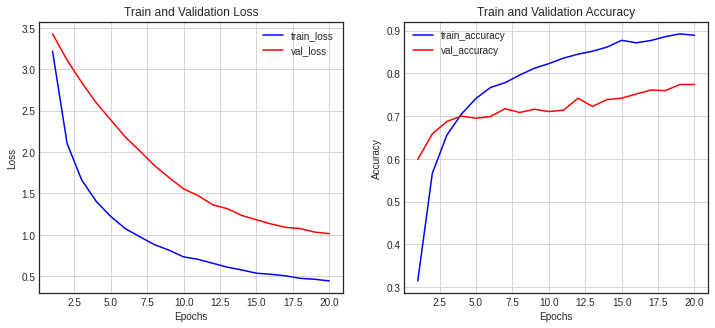

In [7]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [8]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
# 모델 평가
test_loss, test_acc = model.evaluate(x_test, one_hot_test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

71/71 [==============================] - 0s 2ms/step - loss: 1.0459 - accuracy: 0.7640
Test Loss: 1.0458976030349731
Test Accuracy: 0.7640249133110046
